Импорт библиотек и загрузка данных

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Анализ данных и обработка

In [18]:
train_data.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [19]:
# Преобразование даты в индекс
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Агрегирование продаж по месяцам
train_sales = train_data['number_sold'].resample('ME').sum()
test_sales = test_data['number_sold'].resample('ME').sum()

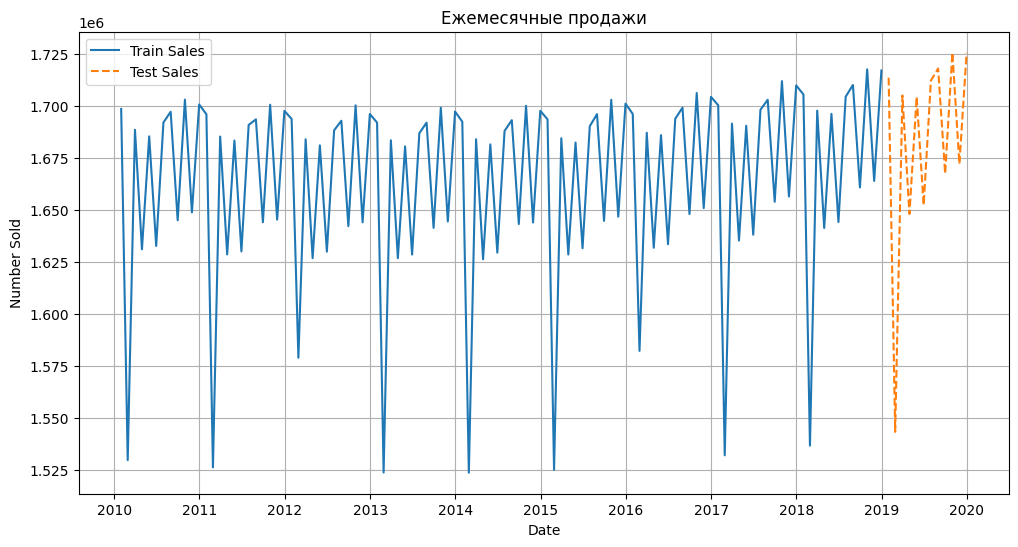

In [20]:
# Анализ временного ряда
plt.figure(figsize=(12, 6))
plt.plot(train_sales, label="Train Sales")
plt.plot(test_sales, label="Test Sales", linestyle='--')
plt.title("Ежемесячные продажи")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.grid()
plt.show()

На графике видны сезонные колебания продаж, что делает модели SARIMA более подходящими для прогнозирования.

In [21]:
# Проверка на стационарность
adf_test = adfuller(train_sales.dropna())
adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4],
    "Stationary": adf_test[1] < 0.05
}
adf_result

{'ADF Statistic': 0.5343272139492738,
 'p-value': 0.9858799331312138,
 'Critical Values': {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 'Stationary': False}

Временной ряд не стационарен (p-value > 0.05). Для корректного моделирования потребуется дифференцирование данных.

ADF Statistic (дифференцированный ряд): -28.855442
p-value: 0.000000


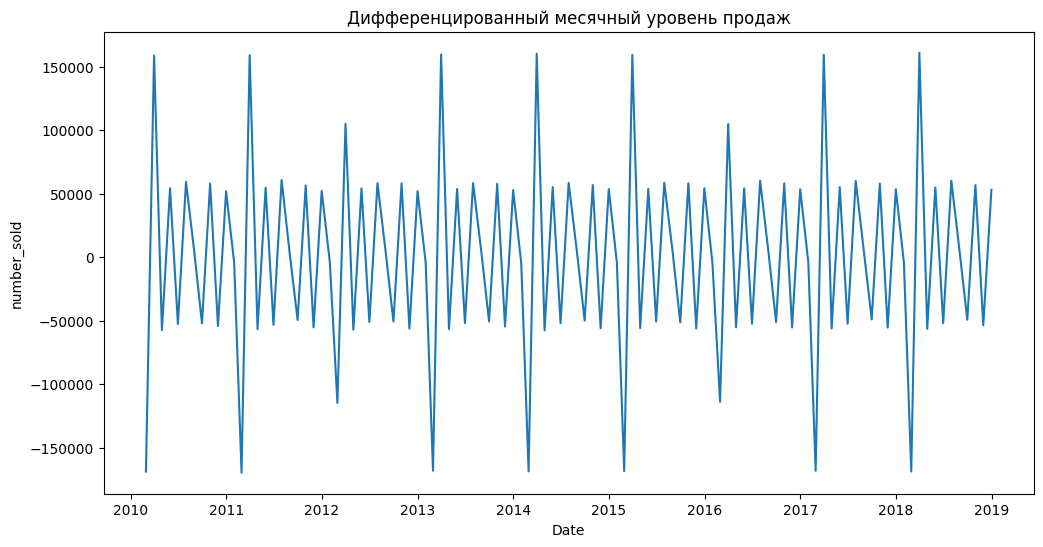

In [22]:
train_sales_diff = train_sales.diff().dropna()

#тест Дики-Фуллера на дифференцированном ряде
result_diff = adfuller(train_sales_diff)
print('ADF Statistic (дифференцированный ряд): %f' % result_diff[0])
print('p-value: %f' % result_diff[1])

plt.figure(figsize=(12, 6))
sns.lineplot(data=train_sales_diff)
plt.title('Дифференцированный месячный уровень продаж')
plt.show()

Подбор лучших параметров для модели

In [23]:
# Параметры для перебора
p = d = q = range(0, 3) 
P = D = Q = range(0, 2)
S = [12]  # сезонный период

# Лучшие результаты
best_metrics = {
    "MAPE": float("inf"),
    "RMSE": float("inf"),
    "R2": -float("inf"),
    "AIC": float("inf"),
    "BIC": float("inf"),
    "order": None,
    "seasonal_order": None
}

for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q, S):
        try:
            # Обучение модели
            model = SARIMAX(train_sales, order=order, seasonal_order=seasonal_order)
            results = model.fit(disp=False)
            
            # Прогноз
            forecast = results.get_forecast(steps=len(test_sales))
            forecast_mean = forecast.predicted_mean
            
            # Метрики
            mape = mean_absolute_percentage_error(test_sales, forecast_mean)
            rmse = np.sqrt(mean_squared_error(test_sales, forecast_mean))
            r2 = r2_score(test_sales, forecast_mean)
            aic = results.aic
            bic = results.bic
            
            # Сравнение и обновление лучших параметров
            if mape < best_metrics["MAPE"] and rmse < best_metrics["RMSE"] and r2 > best_metrics["R2"]:
                best_metrics.update({
                    "MAPE": mape,
                    "RMSE": rmse,
                    "R2": r2,
                    "AIC": aic,
                    "BIC": bic,
                    "order": order,
                    "seasonal_order": seasonal_order
                })
        except Exception as e:
            continue

print(f"Лучшие параметры: order={best_metrics['order']}, seasonal_order={best_metrics['seasonal_order']}")
print(f"MAPE: {best_metrics['MAPE']:.4f}, RMSE: {best_metrics['RMSE']:.4f}, R²: {best_metrics['R2']:.4f}")
print(f"AIC: {best_metrics['AIC']:.4f}, BIC: {best_metrics['BIC']:.4f}")

Лучшие параметры: order=(2, 1, 2), seasonal_order=(0, 1, 1, 12)
MAPE: 0.0004, RMSE: 786.1496, R²: 0.9997
AIC: 2130.0035, BIC: 2145.3268


Построение модели, оценка качества предсказаний с помощью метрик mape, rmse, r2 (доп. AIC, BIC)

                                      SARIMAX Results                                       
Dep. Variable:                          number_sold   No. Observations:                  108
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1059.002
Date:                              Mon, 16 Dec 2024   AIC                           2130.004
Time:                                      00:32:28   BIC                           2145.327
Sample:                                  01-31-2010   HQIC                          2136.195
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2865      6.162     -0.046      0.963     -12.364      11.791
ar.L2          0.58

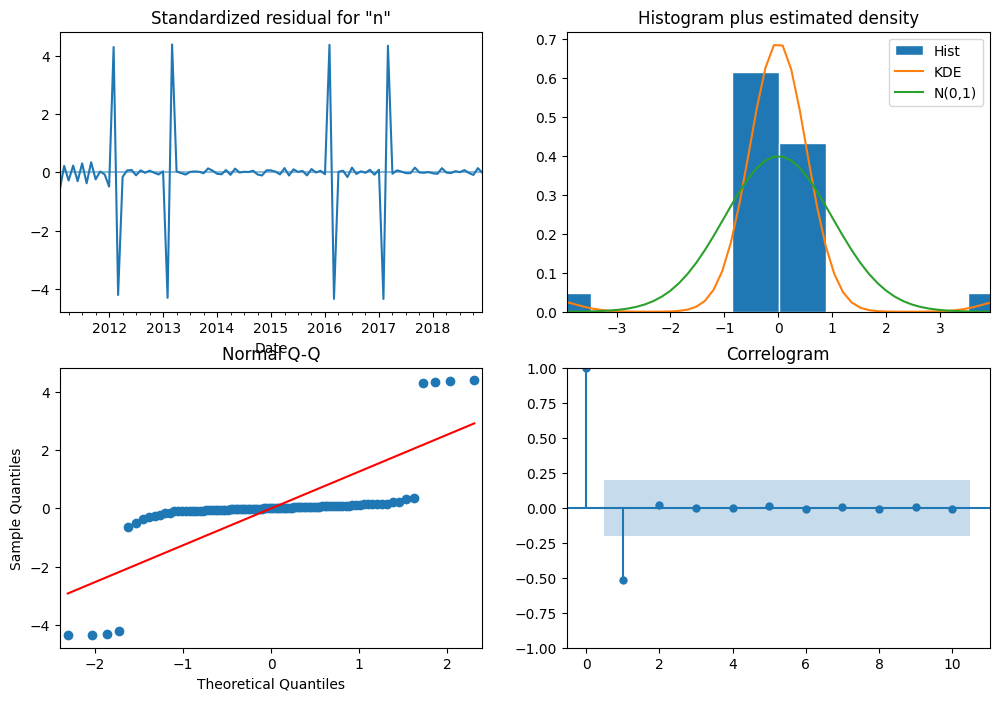

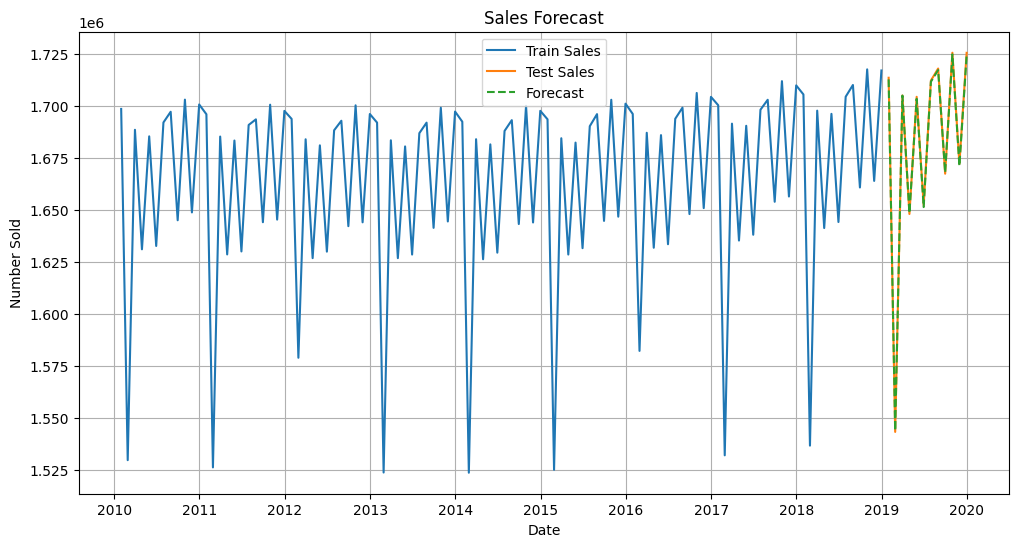

MAPE: 0.0004, RMSE: 786.1496, R^2: 0.9997
AIC: 2130.0035, BIC: 2145.3268


In [24]:
# Настройка модели SARIMA
order = (2, 1, 2)
seasonal_order = (0, 1, 1, 12)

model = SARIMAX(train_sales,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True)
results = model.fit(disp=False)
print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Прогнозирование
forecast = results.get_forecast(steps=len(test_sales))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(train_sales, label="Train Sales")
plt.plot(test_sales, label="Test Sales")
plt.plot(forecast_mean, label="Forecast", linestyle='--')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.grid()
plt.show()

# Оценка качества прогноза
mape = mean_absolute_percentage_error(test_sales, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_sales, forecast_mean))
r2 = r2_score(test_sales, forecast_mean)
aic = results.aic
bic = results.bic

print(f"MAPE: {mape:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")
print(f"AIC: {aic:.4f}, BIC: {bic:.4f}")

Оценка качества модели с помощью анализа остатков модели

In [25]:
residuals = results.resid

# ADF-тест на стационарность остатков
adf_result = adfuller(residuals)
print("\nADF-тест на стационарность остатков:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Критические значения:")
for key, value in adf_result[4].items():
    print(f"{key}: {value:.4f}")

if adf_result[1] <= 0.05:
    print("Остатки стационарны.")
else:
    print("Остатки нестационарны.")


ADF-тест на стационарность остатков:
ADF Statistic: -15.5918
p-value: 0.0000
Критические значения:
1%: -3.4930
5%: -2.8890
10%: -2.5814
Остатки стационарны.
